In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.basemap import Basemap
import matplotlib as mpl

In [3]:
df = pd.read_csv('Routing/aisToTrondheim.csv', index_col = 'TimestampPosition', parse_dates = True)
df = df.drop(columns=['dummy'])

In [4]:
trond_lat = [63.43049]
trond_lon = [10.39506]

# add velocity components to df
df['Heading'] = np.radians(df['Heading'])
df['VelocityLongitude'] = df['SpeedOverGround']*np.sin(df['Heading'])
df['VelocityLatitude'] = df['SpeedOverGround']*np.cos(df['Heading'])
df['DistTrondheim'] = np.sqrt((df['Longitude'].values - trond_lon)**2 + (df['Latitude'].values - trond_lat)**2)
#df.head()

In [5]:
# extract subset of original df to analyze. Dataset to big to analyze all together

df_subset = df[df['ShipType'].isin(['tugboats'])]

# get rid of hours, minutes and seconds in Timestamp col/ìdx
date = df_subset.index.to_period('d')
unique_dates = date.drop_duplicates()

route0 = df_subset.loc[str(unique_dates[0])]
route1 = df_subset.loc[str(unique_dates[1])]

In [6]:
date_freq = date.value_counts()

In [8]:
# find routes sorting by unique dates. Add new column to df_subset determining travelling direction
for i in range(unique_dates.shape[0]):
    
    route = df_subset.loc[str(unique_dates[i])]

    if route['DistTrondheim'].values[-1] < route['DistTrondheim'].values[0]:
        df_subset.loc[route.index, 'Direction'] = 'To'  
        
        count = 0
        for j in range(route.shape[0] - 1):
            if route['DistTrondheim'].values[j + 1] < route['DistTrondheim'].values[j]:
                #dist decreasing
                count = 0
            else:
                #dist increasing
                count += 1
            if count == 3:
                #Ship could be travelling through
                df_subset.loc[route.index, 'Direction'] = 'Through'
                break
    else:
        df_subset.loc[route.index, 'Direction'] = 'From'


In [9]:
df_ToTrondheim = df_subset.loc[df_subset['Direction'] == 'To', 
                              ['Longitude', 'Latitude', 'VelocityLongitude', 'VelocityLatitude', 'DistTrondheim']]

In [10]:
uniqueIMOS = df_subset['IMONumber'].drop_duplicates()

In [11]:
#df_subset.index.year 
#df_subset.index.month
#df_subset.index.day

In [116]:
# grid boundaries
minlon = max(-180, min(df['Longitude']))
minlat = max(-90, min(df['Latitude']))
maxlon = min(180, max(df['Longitude']))
maxlat = min(90, max(df['Latitude']))

nx, ny = 3, 3

lat0 = (maxlat + minlat)/2 
lon0 = (maxlon + minlon)/2
lat1 = (maxlat + minlat)/2-20
lon_bins = np.linspace(minlon, maxlon, nx)
lat_bins = np.linspace(minlat, maxlat, ny)

#grid for flow computations
nxx, nyy = 40, 20
x_flow = np.linspace(minlon, maxlon, nxx)
y_flow = np.linspace(minlat, maxlat, nyy)

X, Y = np.meshgrid(x_flow, y_flow)

In [117]:
def find_land(x, y):
    """
    Returns:
    1 if point is over land
    0 if point is over sea
    """
    bool_arr = np.zeros((len(x), len(y)))
    for i in range(len(x)):
        for j in range(len(y)):
            bool_arr[i][j] = m.is_land(x[i], y[j])
    return bool_arr
land_vals = find_land(x_flow, y_flow)
land_vals = np.rot90(land_vals)

sea_vals = 1 - land_vals 

Y = np.flip(Y)
X_sea = X*sea_vals
Y_sea = Y*sea_vals

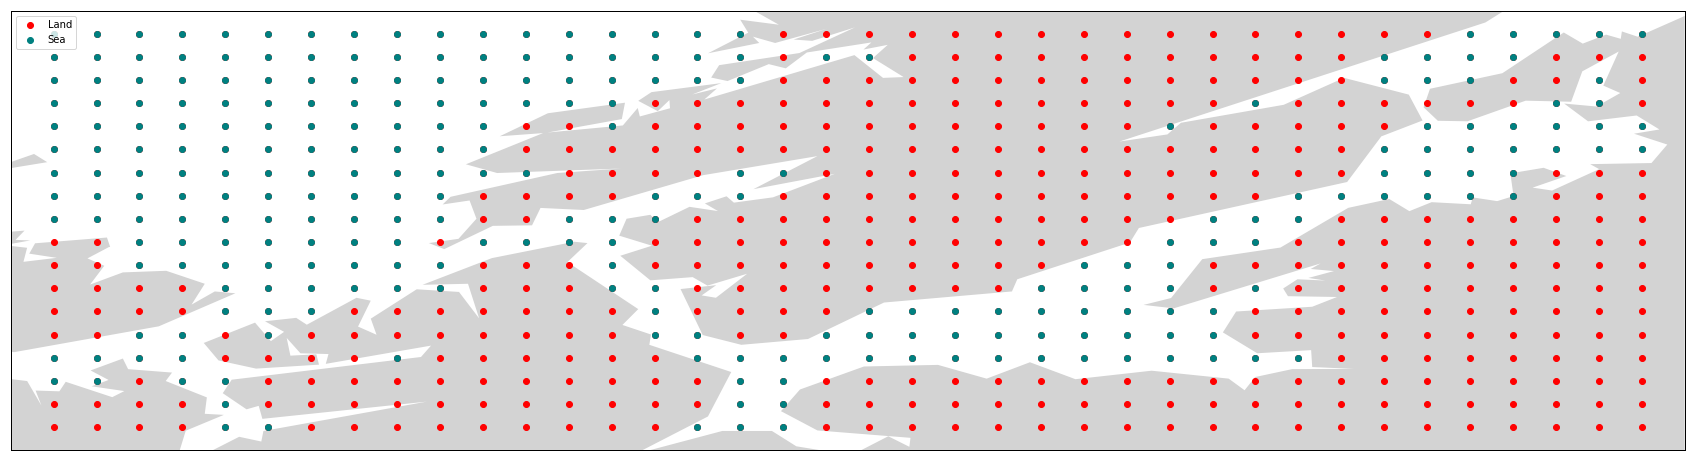

In [123]:
fig, ax = plt.subplots(figsize = (30, 30))
m = Basemap(llcrnrlon = minlon, llcrnrlat = minlat, urcrnrlon = maxlon, urcrnrlat = maxlat,
            resolution = 'i', projection = 'cyl', lat_0=lat0, lon_0 = lon0, lat_ts = lat1)

# labels = [left, right, top, bottom]
#m.drawparallels(lat_bins, labels = [False, True, True, False])
#m.drawmeridians(lon_bins, labels = [True, False, True, False])

# formatting plot
m.drawmapboundary(fill_color = 'white')
m.fillcontinents(color = 'lightgrey', lake_color = 'white',zorder=1)  

# Trondheim
trond_x, trond_y = m(trond_lon, trond_lat)
labels = ['Trondheim']
#m.plot(trond_x, trond_y, color = 'black', marker = 's', markersize = 15)
#for label, xpt, ypt in zip(labels, trond_x, trond_y):
#    plt.text(xpt, ypt, label)



m.scatter(X[1:-1,1:-1], Y[1:-1, 1:-1], marker='o', color='red', zorder=2, label='Land')
m.scatter(X_sea[1:-1,1:-1], Y_sea[1:-1, 1:-1], color='teal', zorder=3, label='Sea')
plt.legend()


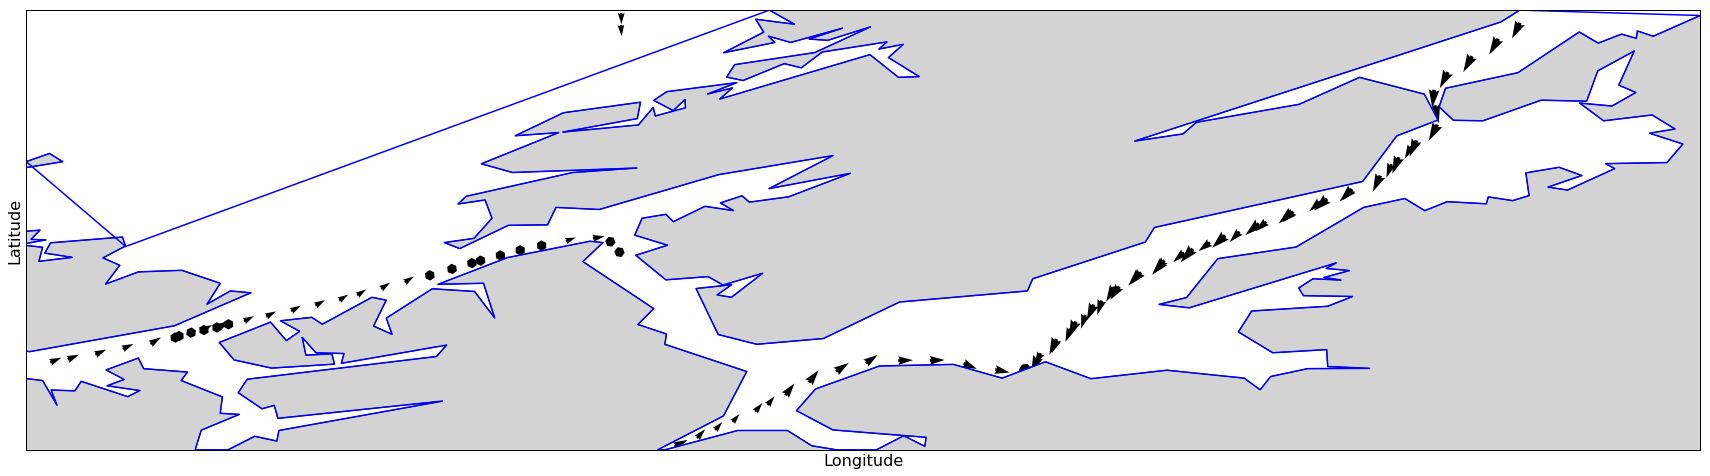

In [121]:
fig, ax = plt.subplots(figsize = (30, 30))
m = Basemap(llcrnrlon = minlon, llcrnrlat = minlat, urcrnrlon = maxlon, urcrnrlat = maxlat,
            resolution = 'i', projection = 'cyl', lat_0=lat0, lon_0 = lon0, lat_ts = lat1)

# formatting plot
m.drawmapboundary(fill_color = 'white')
m.fillcontinents(color = 'lightgrey', lake_color = 'white',zorder=1)  

# plot ships    
m.quiver(df_ToTrondheim['Longitude'], df_ToTrondheim['Latitude'],
         df_ToTrondheim['VelocityLongitude'], df_ToTrondheim['VelocityLatitude'], scale=1000)

# coastline 
coast = m.drawcoastlines()
coordinates = np.vstack(coast.get_segments())
m.plot(coordinates[:, 0], coordinates[:, 1], color = 'blue')

plt.xlabel('Longitude', fontsize = 16)
plt.ylabel('Latitude', fontsize = 16)
